# Import Modules

In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm
import numpy as np

# Variables

In [3]:
# text file name 
# SENTINEL Paths
SENTINEL_PATH_ORIGINAL = "data/modelling/baseline_datasets/20250720_sentinel_1_bands.txt"
SENTINEL_PATH_DAYOF = "data/modelling/baseline_datasets/20250722_sentinel_1_bands_dayof.txt"

SOIL_PATH = "data/modelling/baseline_datasets/250627_lucas_2018_cleaned.csv"

# Load the Raw Data Files

In [4]:
# Function to read text files as json
def read_txt_as_df(filepath):
    rows = []
    with open(filepath, 'r+') as f:
        for line in f:
            try: 
                data = json.loads(line)
                if isinstance(data, dict):
                    rows.append(data)
            except json.JSONDecodeError:
                continue

    # Convert to a dataframe
    df = pd.DataFrame(rows)
    return df

In [5]:
# Sentinel
sentinel_older = read_txt_as_df(SENTINEL_PATH_ORIGINAL)
sentinel_dayof = read_txt_as_df(SENTINEL_PATH_DAYOF)

# Read Soil
soil = pd.read_csv(SOIL_PATH)

## Merge the Dataframes

In [6]:
# Columns to join on
cols = ['point_id', 'survey_date', 'image_date', 'days_diff']

In [15]:
# Concatenate all sentinel Dataframes
sentinel_all = pd.concat([sentinel_older, sentinel_dayof])

# Correct datetime format
sentinel_all['survey_date'] = pd.to_datetime(sentinel_all['survey_date'])
sentinel_all['image_date'] = pd.to_datetime(sentinel_all['image_date'])

# Calculate days between survey and image date
sentinel_all['days_diff'] = (sentinel_all['survey_date'] - sentinel_all['image_date']).dt.days

print(f"Length of joined dataframe: {len(sentinel_all)}")

# Drop images taken on the same date for each point ID
sentinel_all = sentinel_all.drop_duplicates(subset=['point_id', 'image_date'], keep='last')
print(f"Length of de-duplicated dataframe: {len(sentinel_all)}")

Length of joined dataframe: 369479
Length of de-duplicated dataframe: 242199


# Process Bands: Calculate mean of array

In [8]:
sentinel_merged = sentinel_all.copy()

In [16]:
# List of bands
bands = ['VV', 'VH']

# Compute the mean for each array column
for band in bands:
    array_col = f"{band}_array"
    mean_col = f"{band}_mean"

    def calc_mean(array):
        if isinstance(array, list) and all(isinstance(row, list) for row in array):
            flat = [val for row in array for val in row if val is not None]
            return np.mean(flat) if flat else None
        return None

    sentinel_merged[mean_col] = sentinel_merged[array_col].apply(calc_mean)
    sentinel_merged[f"{band}_diff"] = sentinel_merged[mean_col] - sentinel_merged[f"{band}_center"]

In [17]:
print(f"Length of Sentinel Merged DataFrame: {len(sentinel_merged)}")

Length of Sentinel Merged DataFrame: 242199


In [18]:
df = sentinel_merged.copy()

## Evaluate the Difference Between Array Mean and Centre Values

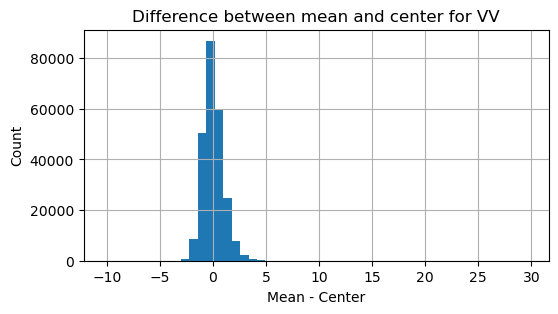

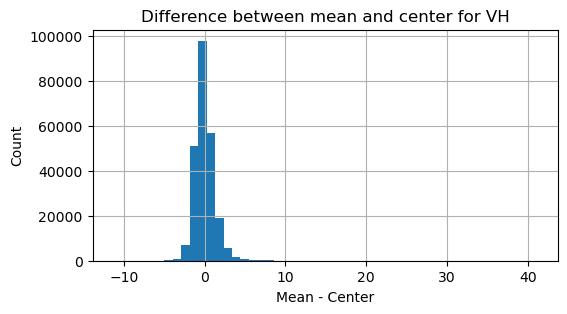

In [19]:
# Plot the difference between mean and center
for band in bands:
    df[f"{band}_diff"].hist(bins=50, figsize=(6,3))
    plt.title(f"Difference between mean and center for {band}")
    plt.xlabel("Mean - Center")
    plt.ylabel("Count")
    plt.show()

## Number of Images per Point ID

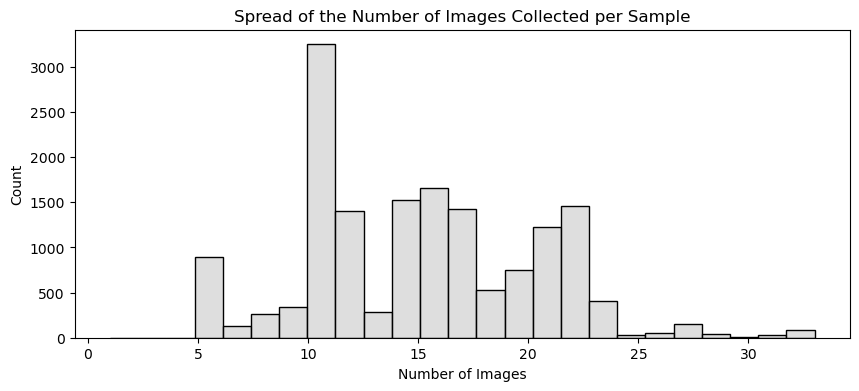

In [20]:
# Find out how many images there are for each point ID
summary = df.groupby(['point_id']).agg(
                total_images=('image_date', 'count'),
            ).reset_index()

plt.figure(figsize=(10,4))
sns.histplot(summary['total_images'], bins=25, color='lightgrey')
plt.xlabel("Number of Images")
plt.title("Spread of the Number of Images Collected per Sample")
plt.savefig('./graphs/sentinel/number_of_images_per_sample.png', dpi=300)
plt.show()

In [21]:
# Find out why some have over 4 images
summary[summary['total_images']>20].sort_values(by='total_images', ascending=False).head()

,point_id,total_images
12382,50424986,33
12449,50505168,33
12319,50344932,33
11865,49765086,33
10588,47704864,33


In [23]:
# Preview one of the Points with 8 images
df[df['point_id']==50424986].image_date.nunique()

33

In [24]:
# Drop duplicates based on point id, survey date and image_date
df = df.drop_duplicates(subset=['point_id', 'survey_date', 'image_date'])

In [25]:
len(df)

242199

## Null Analysis

## Points where images could not be found

In [26]:
null_point_df = df[df['image_date'].isnull()]
print(f"Number of points without images: {null_point_df['point_id'].nunique()}")

Number of points without images: 433


In [27]:
# Find out the locations of images with no images - merge first
soil['SURVEY_DATE'] = pd.to_datetime(soil['SURVEY_DATE'])
null_point_df = null_point_df.merge(soil, how='left', left_on=['point_id', 'survey_date'], right_on=['POINTID', 'SURVEY_DATE'])
null_point_df.groupby('country_name').agg('count').reset_index()[['country_name', 'point_id']]

,country_name,point_id
0,Austria,8
1,Belgium,1
2,Bulgaria,9
3,Croatia,1
4,Cyprus,1
5,Czechia,6
6,Denmark,2
7,Estonia,6
8,Finland,54
9,France,56


In [28]:
# Drop rows with no images
df = df[~df['image_date'].isnull()]
print(f"Number of points remaining: {df['point_id'].nunique()}")

Number of points remaining: 15939


## Mean, Centre and Array Values

In [29]:
# Summary of mean vs. the center value
summary = []
for band in bands:
    corr = sentinel_merged[[f"{band}_center", f"{band}_mean"]].corr().iloc[0,1]
    std_center = sentinel_merged[f"{band}_center"].std()
    std_mean = sentinel_merged[f"{band}_mean"].std()
    summary.append({
        'band': band,
        'correlation': corr,
        'std_center': std_center,
        'std_mean': std_mean
    })

summary_df = pd.DataFrame(summary)

In [30]:
summary_df['pct_diff'] = (1-(summary_df['std_center'] / summary_df['std_mean'])) * 100
summary_df

,band,correlation,std_center,std_mean,pct_diff
0,VV,0.964440,3.486128,3.156369,-10.447395
1,VH,0.953229,4.289665,3.827447,-12.076391


## Difference between Mean and Centre

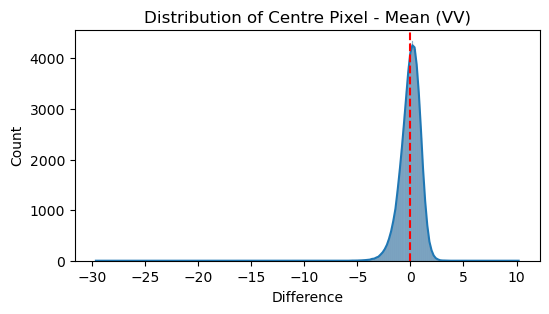

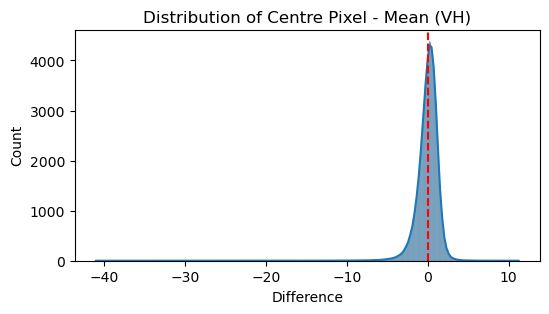

In [31]:
for band in bands:
    diff = df[f'{band}_center'] - df[f'{band}_mean']
    plt.figure(figsize=(6,3))
    sns.histplot(diff, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Distribution of Centre Pixel - Mean ({band})")
    plt.xlabel("Difference")
    plt.ylabel("Count")
    plt.show()

## Save as CSV

In [32]:
SENTINEL_CSV_PROCESSED = "data/modelling/baseline_datasets/processed/20250722_sentinel_1_mean_band_values_all_images.csv"

In [33]:
# Save sentinel as CSV
df.to_csv(SENTINEL_CSV_PROCESSED, index=False)

# Load CSV

In [3]:
df = pd.read_csv(SENTINEL_CSV_PROCESSED)

In [4]:
df['survey_date'] = pd.to_datetime(df['survey_date'])
df['image_date'] = pd.to_datetime(df['image_date'])

df['days_diff'] = (df['survey_date'] - df['image_date']).dt.days

# Exploration

## Time Between Images per Point ID

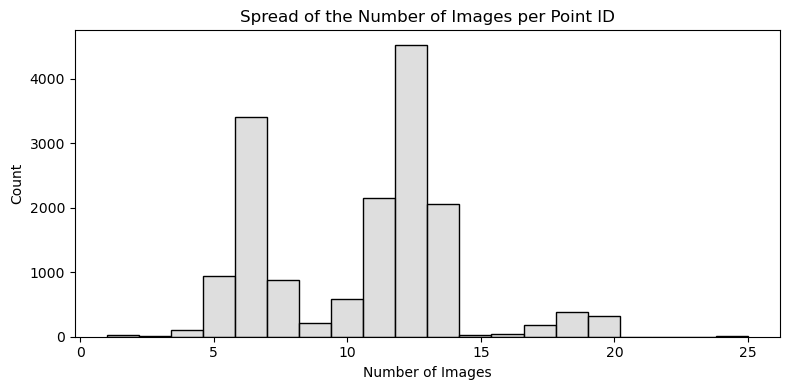

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(count_df['image_count'], bins=20, color="lightgrey")
plt.xlabel("Number of Images")
plt.title("Spread of the Number of Images per Point ID")
plt.tight_layout()
plt.savefig("./graphs/sentinel/histplot_image_count_per_point.png", dpi=300)
plt.show()

In [13]:
# Sort by more recent images per point, calculate time between each 
df_sorted = df.sort_values(by=['point_id', 'image_date'])
df_sorted['time_diff'] = df_sorted.groupby('point_id')['image_date'].diff().dt.days

# Average the time between images per point
avg_time_between_images = df_sorted.groupby('point_id')['time_diff'].mean()

print(avg_time_between_images.describe())

count    15854.000000
mean         3.419928
std          1.328354
min          1.000000
25%          2.500000
50%          2.700000
75%          5.000000
max         14.000000
Name: time_diff, dtype: float64


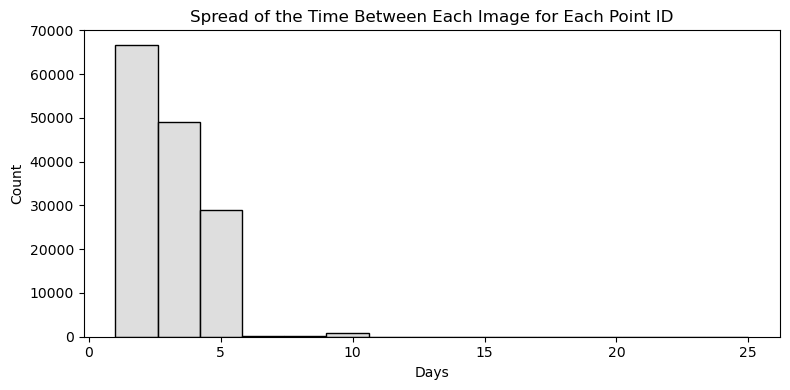

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(df_sorted['time_diff'], bins=15, color="lightgrey")
plt.xlabel("Days")
plt.title("Spread of the Time Between Each Image for Each Point ID")
plt.tight_layout()
plt.savefig("./graphs/sentinel/histplot_time_between_images.png", dpi=300)
plt.show()

# Select Most Recent Images

### Create Column: days between survey date and satellite image taken

In [56]:
df = mean_df.copy()

In [57]:
# Calculate the days between the footage for sentinel 
df['image_date'] = pd.to_datetime(df['image_date'])
df['survey_date'] = pd.to_datetime(df['survey_date'])

df['days_diff'] = (df['image_date'] - df['survey_date']).dt.days

In [58]:
# Select the closest day
dup_cols = ['point_id', 'survey_date']
closest = df.groupby(dup_cols, as_index=False)['days_diff'].max()
closest = closest.merge(df, how='left', on=['point_id', 'survey_date', 'days_diff'])

In [59]:
print(f"Number of samples: {len(closest)}")
print(f"Number of unique point IDs: {closest['point_id'].nunique()}")

Number of samples: 15877
Number of unique point IDs: 15877


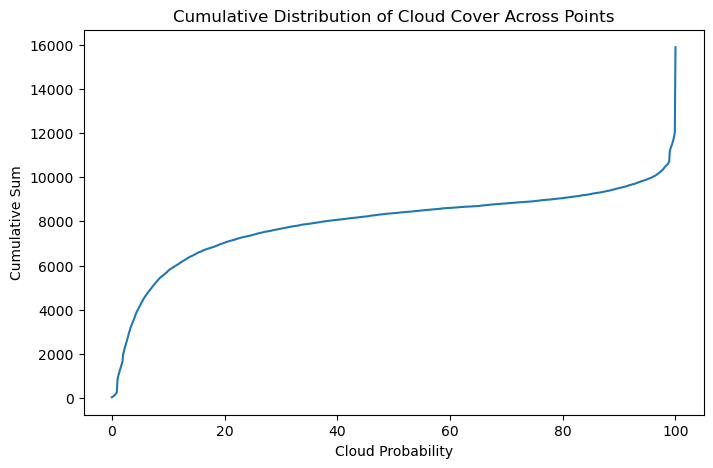

In [61]:
#plot the number of points with each level of cloud cover:
plot_df = closest.groupby('cloud_mean', as_index=False).agg('count')
plot_df['cum_sum'] = plot_df['point_id'].cumsum() 

plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df, x='cloud_mean', y='cum_sum')
plt.title("Cumulative Distribution of Cloud Cover Across Points")
plt.xlabel("Cloud Probability")
plt.ylabel("Cumulative Sum")

plt.show()

## Merge with the Soil DataFrame

In [62]:
merged = closest.merge(soil, how='inner', left_on=['point_id'], right_on=['POINTID'])
len(merged)

15864